# DOPP 2020W Exercise 2

### Before you get started, please read the instructions in this notebook carefully.

## Preliminaries

- Please use only Python **version 3** (3.6+ recommended). It is recommended to run the notebook on the JupyterHub. 

- This notebook will be scored using [nbgrader](https://nbgrader.readthedocs.io/en/stable/user_guide/highlights.html). 
- Please use the code stubs provided, do not rename any functions, and add and modify your code only at the provided markers. 
- Check and make sure that your submission executes without any errors on the JupyterHub before submitting it. Submissions that don't execute will not be accepted.
- do not change cell tags as this may mess up the Validation and auto-grading features.


The submission deadline is **03.12.2020 23:55.**

Sections marked with `# YOUR CODE HERE` must be used to implement the functionality.
Cells containing `YOUR ANSWER HERE` must be used to fill in textual answers.

There is a total of 100 points that can be reached.

In [1]:
# Note: The only imports allowed are those contained in Python's standard library, pandas, numpy, scipy and matplotlib
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

#add imports as needed
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error

## Goal

In this exercise, you will 
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` to visually alayse data,
 * use `scikit-learn` to build prediction models.


The goal of this exercise is to model the relationship between weather observations and the prevalence of new influenza infections.

To investigate a potential relationship, we will use two datasets:
 * daily weather observation data in Vienna (2009-2019)
 * weekly reports on [new influenza infections](https://www.data.gv.at/katalog/dataset/grippemeldedienst-stadt-wien) in Vienna (2009-2019).

The data to be used can be found in the subdirectory named `data`. 

To complete this exercise, you will have to:
* prepare the data, which (at a minimum) involves the following:
    - handling missing values,
    - handling outliers
    - temporal alignment (i.e. convert daily data to weekly data using appropriate aggregation functions),
* analyse the data:
    - compare descriptive statistics,
    - visually investigate the raw data to gain an understanding of the data, identify patterns, outliers etc.,
    - look at the relationship between the variables of interest,
* model the relationship:
    - fit a model that predicts new infections from weather observation data.

## Task 1: Load Data

Total number of points for completing this task: **10**

### Weather observations

As a first step, implement the method `load_weather_data()`, which should read all individual (yearly) data sets from the csv files in `data` into a single `pd.DataFrame` and return it. 

- from the `date` column create `year`, `month`, `week`, `day` columns, where `week` contains the week number of the date. Use Pandas built-in datetime handling features.
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `week` - `day` (make sure to label them accordingly)
- make sure that all columns are appropriately typed
- make sure that you load all the data (2009-2019)

**Hints:**
 
 - LOOK at the data in the original files
 - It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.
 - Your resulting data frame should look as follows:

![Weather data frame example](weather_data_dataframe_sample.png)

In [2]:
def load_weather_data():
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Add a week column and a hierarchical index (year, month, week, day)
    
    Returns
    --------
    weather_data: data frame containing the weather data
    """
    all_files = glob.glob('data/weather/*.csv')
    dfs = []
    
    for file in all_files:
        df = pd.read_csv(file, sep=';', parse_dates=['date'])
        
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['week'] = df['date'].dt.isocalendar().week
        df['day'] = df['date'].dt.day
        
        dfs.append(df)
    
    weather_data = pd.concat(dfs, ignore_index=True)
    
    weather_data.set_index(['year', 'month', 'week', 'day'], inplace=True)
    weather_data.sort_index(inplace=True)
    
    return weather_data


data_weather = load_weather_data()

In [3]:
assert data_weather.shape == (4017, 17)

# additional tests

Which combination of year+week has the highest number of entries? What causes this number? (You should find the respective entry/entries using pandas)

In [4]:
# fill your answer into these variables
year = 2011
month = 52

entry_nums = data_weather.groupby(level=['year', 'week']).size()
print('Highest number of entries: {}'.format(entry_nums.max()))
print('year+week for highest number of entries: {}'.format(entry_nums.idxmax()))

# the highest number of entries is 8 since the first two days in Jan 2011 also belong to week 52
# (although that's technically week 52 of the previous year)
data_weather.loc[2011, :, 52, :]

Highest number of entries: 8
year+week for highest number of entries: (2011, 52)


date  skyCover_7h  skyCover_14h  skyCover_19h  \
year month week day                                                       
2011 1     52   1   2011-01-01            9             5             8   
                2   2011-01-02           10             9             5   
     12    52   26  2011-12-26            9            10            10   
                27  2011-12-27            9             8             9   
                28  2011-12-28           10            10            10   
                29  2011-12-29            9             9             8   
                30  2011-12-30            9             5             5   
                31  2011-12-31            1             3             7   

                     temp_7h  temp_14h  temp_19h  temp_dailyMean  \
year month week day                                                
2011 1     52   1        0.2       1.8       1.3             0.2   
                2        1.2       2.5       0.0             1.5   
     12    52   26       6.1       7.4       7.7             6.2   
                27       5.4       8.9       7.2             7.1   
                28       6.0       4.7       3.4             5.4   
                29       0.9       5.9       5.2             3.4   
                30       2.1       5.3       3.1             4.1   
                31       2.7       5.7       2.6             3.8   

                     temp_dailyMax  temp_dailyMin  hum_7h  hum_14h  hum_19h  \
year month week day                                                           
2011 1     52   1              2.5           -2.1    81.0     75.0     73.0   
                2              3.0            0.0    85.0     63.0     81.0   
     12    52   26             7.7            4.6    74.0     79.0     75.0   
                27             9.8            4.3    85.0     71.0     78.0   
                28             7.4            3.4    89.0     91.0     95.0   
                29             6.5            0.2   100.0     80.0     68.0   
                30             6.3            1.8    64.0     66.0     81.0   
                31             6.9            0.7    81.0     55.0     75.0   

                     windBeauf_7h  windBeauf_14h  windBeauf_19h  precip  
year month week day                                                      
2011 1     52   1               3              4              5     0.1  
                2               2              3              2     0.3  
     12    52   26              4              3              3  Spuren  
                27              2              2              1  Spuren  
                28              2              3              3       0  
                29              1              3              3  Spuren  
                30              2              5              4  Spuren  
                31              3              3              1     0.1

In [5]:
# hidden tests

### Influenza infections

Load and prepare the second data set (`influenza.csv`), which contains the number of new influenza infections on a weekly basis, as follows:

- get rid of all columns except `Neuerkrankungen pro Woche`, `Jahr`, and `Kalenderwoche`
- rename `Neuerkrankungen pro Woche` to `weekly_infections`
- create a `MultiIndex` from the `Jahr` (→ `year`) and `Kalenderwoche` (→ `week`) columns
- make sure that all columns are appropriately typed
- remove rows with missing infection counts
- your resulting data frame should look as follows:

![Example data frame](influenza_data_dataframe_sample.png)

In [6]:
def load_influenza_data():
    """ 
    Load and prepare the influenza data file
    
    Returns
    --------
    influenza_data: data frame containing the influenza data
    """
    influenza_data = pd.read_csv('data/influenza/influenza.csv', header=0, na_values='-',
                                 usecols=['Neuerkrankungen pro Woche', 'Jahr', 'Kalenderwoche'])
    
    influenza_data.columns=['year', 'week', 'weekly_infections']
    
    influenza_data.dropna(inplace=True)
    influenza_data['weekly_infections'] = influenza_data['weekly_infections'].astype(int)
    influenza_data['week'] = influenza_data['week'].str[:-7].astype(int)
    
    influenza_data.set_index(['year', 'week'], inplace=True)
    
    return influenza_data

data_influenza = load_influenza_data()

In [7]:
assert data_influenza.shape == (258, 1)
# additional tests

Which combination of year+week shows the highest number of infections?

In [8]:
# fill your answer into these variables
year = 2017
month = 1

print('Highest number of infections: {}'.format(data_influenza['weekly_infections'].max()))
print('year+week for highest number of infections: {}'.format(data_influenza['weekly_infections'].idxmax()))

Highest number of infections: 19700
year+week for highest number of infections: (2017, 1)


In [9]:
# hidden tests

## Task 2: Handling Missing Values

Total number of points for completing this task: **15**

If you take a closer look at the data, you will notice that a few of the observations are missing.

There are a wide range of standard strategies to deal with such missing values, including:

- row deletion
- substitution methods (e.g., replace with mean or median)
- hot-/cold-deck methods (impute from a randomly selected similar record)
- regression methods

To decide which strategy is appropriate, it is important to investigate the mechanism that led to the missing values to find out whether the missing data is missing completely at random, missing at random, or missing not at random. 

 - **MCAR** (Missing Completely At Random) means that there is no relationship between the missingness of the data and any of the values.
 - **MAR** (Missing At Random) means that that there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
 - **MNAR** (Missing Not At Random) means that there is a systematic relationship between the propensity of a value to be missing and its values. 

To find out more about what mechanisms may have caused the missing values, you talked to the metereologist that compiled the data. 
She told you that she does not know why some of the temperature readings are missing, but that it may be that someone forgot to record them. In any case, it is likely that the propensity of a temperature value to be missing does not have anything to do with the weather itself.

As far as the missing humidity readings are concerned, she says that according to her experience, she suspects that the humidity sensor is less reliable in hot weather.

Check the plausibility of these hypotheses in the data, consider the implications, and devise an appropriate strategy to deal with the various missing values.

To implement your strategy, you can use a range of standard mechanisms provided by Pandas, by implementing `handle_missingValues_simple`, or implement a custom strategy (for extra points, by implementing `handle_missingValues_advanced`).

In [10]:
temp_data = data_weather[['temp_7h', 'temp_14h', 'temp_19h']]

# if we examine the rows containing NaN temperatures, there isn't a row where all 3 daily readings are missing
assert temp_data.isna().all(axis=1).sum() == 0

# instead, the NaNs seem to appear randomly for one of the daily readings, as can be seen in the displayed data frame
# -- the temperature data is MCAR
display(data_weather[temp_data.isna().any(axis=1)])



hum_data = data_weather[['hum_7h', 'hum_14h', 'hum_19h']]

# humidity NaNs always appear for all 3 daily readings
assert hum_data.isna().all(axis=1).sum() == hum_data.isna().any(axis=1).sum()

# to check if that is related to hot weather, we'll compare the means of the temp_dailyMean column
# for NaN humidities and not-NaN humidities
hum_na_mean_temp = data_weather[hum_data.isna().all(axis=1)]['temp_dailyMean'].mean()
hum_notna_mean_temp = data_weather[hum_data.notna().all(axis=1)]['temp_dailyMean'].mean()

# the temperature mean for NaN humidities seems to be more than twice as high as for the not-NaN humidities
# this agrees with the hypothesis and so the humidity data is MAR
# -- its missingness depends on the observed data (i.e. the temperature)
print('NaN mean temp: {:.2f}, not-NaN mean temp: {:.2f}'.format(hum_na_mean_temp, hum_notna_mean_temp))

date  skyCover_7h  skyCover_14h  skyCover_19h  \
year month week day                                                       
2009 1     2    6   2009-01-06           10            10            10   
           3    13  2009-01-13           10            10            10   
     2     6    6   2009-02-06           10             9             9   
           7    12  2009-02-12            8             9             6   
                13  2009-02-13            8             8            10   
...                        ...          ...           ...           ...   
2019 12    49   3   2019-12-03            9             7             8   
                5   2019-12-05           10             9             9   
           50   10  2019-12-10            5             1             0   
                11  2019-12-11            0             1             0   
           51   17  2019-12-17           10            10             9   

                     temp_7h  temp_14h  temp_19h  temp_dailyMean  \
year month week day                                                
2009 1     2    6       -4.4       NaN      -4.1            -2.9   
           3    13      -6.6      -6.0       NaN            -6.3   
     2     6    6        2.3       4.4       NaN             3.2   
           7    12       NaN       2.2      -0.6             1.0   
                13       NaN       0.0      -0.6            -1.2   
...                      ...       ...       ...             ...   
2019 12    49   3        2.9       NaN       1.3             3.3   
                5       -0.7       NaN      -0.4            -0.1   
           50   10       6.3       NaN       3.7             5.2   
                11      -2.3       NaN      -0.3             0.5   
           51   17       NaN       6.1       3.5             4.9   

                     temp_dailyMax  temp_dailyMin  hum_7h  hum_14h  hum_19h  \
year month week day                                                           
2009 1     2    6             -1.3           -4.5    87.0     86.0     85.0   
           3    13            -5.8           -6.8    88.0     87.0     89.0   
     2     6    6              4.8            1.6    93.0     88.0     92.0   
           7    12             2.7           -0.7    71.0     63.0     58.0   
                13             0.2           -2.5    66.0     56.0     55.0   
...                            ...            ...     ...      ...      ...   
2019 12    49   3              5.5            1.0    69.0     55.0     83.0   
                5              1.3           -1.4    82.0     75.0     82.0   
           50   10             7.2            3.2    75.0     49.0     64.0   
                11             3.7           -2.7    91.0     61.0     76.0   
           51   17             6.2            3.5   100.0     90.0     98.0   

                     windBeauf_7h  windBeauf_14h  windBeauf_19h  precip  
year month week day                                                      
2009 1     2    6               2              3              3  Spuren  
           3    13              3              3              3  Spuren  
     2     6    6               2              1              1  Spuren  
           7    12              3              3              3       0  
                13              4              4              4  Spuren  
...                           ...            ...            ...     ...  
2019 12    49   3               3              3              2     0.1  
                5               3              3              3       0  
           50   10              4              4              3       0  
                11              1              3              2       0  
           51   17              1              0              1       0  

[572 rows x 17 columns]

NaN mean temp: 25.14, not-NaN mean temp: 11.30


In [11]:
def handle_missingValues_simple(incomplete_data):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    complete_data = incomplete_data.interpolate()
    
    return complete_data


def handle_missingValues_advanced (incomplete_data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    data: data frame not containing any missing values
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return complete_data
    
data_weather_complete = handle_missingValues_simple(data_weather)

In [12]:
# hidden tests

In [13]:
# hidden tests

In [14]:
# hidden tests

###  Discussion

#### Pros and Cons of strategies for dealing with missing data

In the cell provided below, discuss the PROs and CONs of various strategies (row deletion, imputation, hot deck methods etc.) for dealing with missing data. Discuss when it is appropriate to use each method.

The main benefit of row deletion is that it is very simple to apply to any data set. The downside of this approach is that it reduces the size of the data set, so it is unsuitable for small data sets. Additionaly, it is not very appropriate to use if the missing data is not MCAR since it might lead to bias.

Imputation methods are good since the size of the data set is preserved. However, if they are not carefully applied the variance in the data set might be reduced and bias could be introduced.

Methods such as regression or KNN imputation can be useful because they don't replace every missing value of a variable with the same value -- regression predicts the missing values based on variables with complete cases and KNN replaces them with the average of k similar samples. On the other hand, they could be computationally inefficient (KNN for many variables) or fit the values too well (regression), so fixed value/mean/mode/median imputation might be preferred.

Hot-deck imputation replaces the missing value with the value from a randomly selected similar sample -- it is again quite simple, but also runs the risk of introducing bias. In that case, cold-deck imputation might be better as it selects values from a different data set.

#### Your chosen strategy <span style="color:blue">

Explain your chosen strategy for dealing with missing values for the various attributes in the cell below.


The strategy chosen for all the attributes is (linear) interpolation. This method was used because it is very simple to apply in Pandas and doesn't substitute all the missing values with the same provided value (such as a given constant, mean, etc.). Additionally, it computes the new values within the range of the known values, so it doesn't affect the min or max.

## Task 3: Handling Outliers
Total number of points for completing this task: **15**

If you take a closer look at some of the observations, you should notice that some of the temperature values are not particularly plausible (hint: plotting histograms of the distributions helps). Hypothesize on the nature of these outliers and implement a strategy to handle them.

,temp_7h,temp_14h,temp_19h
count,4017.000000,4017.000000,4017.000000
mean,10.842382,16.103099,13.553958
std,11.689142,13.847705,12.768965
min,-45.200000,-40.000000,-40.000000
25%,3.600000,7.300000,5.300000
50%,10.200000,15.500000,12.900000
75%,16.900000,23.200000,19.800000
max,104.400000,140.400000,127.200000


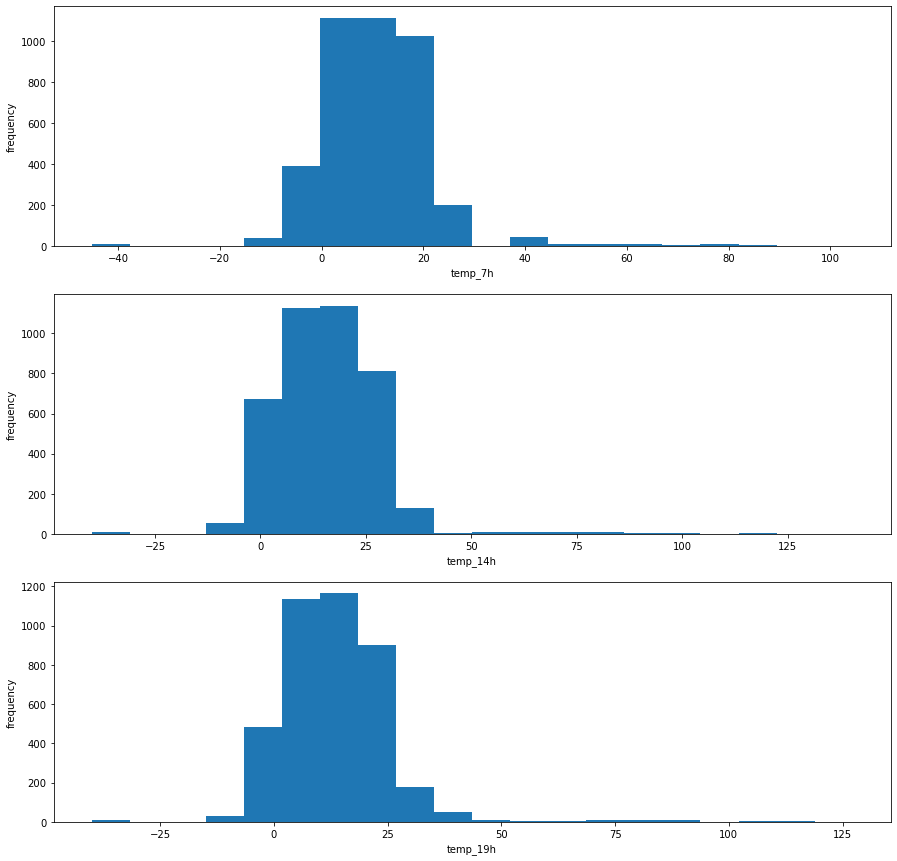

In [15]:
# the histograms below show the different temperature values in the 'temp_7h', 'temp_14h', and 'temp_19h' columns
# considering the lowest and highest recorded temperatures in Vienna and on Earth, some of these values are impossible
# they might have occured due to measurement errors or data entry errors (if the data set was composed manually)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))

ax1.hist(data_weather_complete['temp_7h'], bins=20)
ax1.set_xlabel("temp_7h")
ax1.set_ylabel("frequency")

ax2.hist(data_weather_complete['temp_14h'], bins=20)
ax2.set_xlabel("temp_14h")
ax2.set_ylabel("frequency")

ax3.hist(data_weather_complete['temp_19h'], bins=20)
ax3.set_xlabel("temp_19h")
ax3.set_ylabel("frequency")

data_weather_complete[['temp_7h', 'temp_14h', 'temp_19h']].describe()

In [16]:
def handle_outliers(noisy_data):
    """ 
    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    cleaned_data: data frame with outliers
    """
    temp = noisy_data[['temp_7h', 'temp_14h', 'temp_19h']]
    
    q1s, q3s = np.percentile(temp, [25, 75])
    iqrs = q3s - q1s
    
    lower_bounds = q1s - (1.5 * iqrs)
    upper_bounds = q3s + (1.0 * iqrs)
    
    cleaned_data = noisy_data[((temp >= lower_bounds) & (temp <= upper_bounds)).all(axis=1)]
    
    display(noisy_data[['temp_7h', 'temp_14h', 'temp_19h']].describe())
    display(cleaned_data[['temp_7h', 'temp_14h', 'temp_19h']].describe())
    
    return cleaned_data
    
data_weather_cleaned = handle_outliers(data_weather_complete)

,temp_7h,temp_14h,temp_19h
count,4017.000000,4017.000000,4017.000000
mean,10.842382,16.103099,13.553958
std,11.689142,13.847705,12.768965
min,-45.200000,-40.000000,-40.000000
25%,3.600000,7.300000,5.300000
50%,10.200000,15.500000,12.900000
75%,16.900000,23.200000,19.800000
max,104.400000,140.400000,127.200000


,temp_7h,temp_14h,temp_19h
count,3645.000000,3645.000000,3645.000000
mean,9.683342,14.640919,12.228989
std,7.976033,9.458580,8.764692
min,-14.900000,-8.800000,-10.700000
25%,3.500000,7.000000,5.100000
50%,9.800000,14.800000,12.400000
75%,16.300000,22.300000,19.100000
max,34.250000,34.400000,32.900000


In [17]:
# hidden tests

In [18]:
# hidden tests

In [19]:
# hidden tests

#### Your chosen strategy

In the cell below, explain your chosen strategy for dealing with outliers.


The IQR strategy for dealing with outliers was used, where IQR is defined by the difference between the 75th and 25th percentiles (i.e. the 3rd and 1st quartiles). Traditionally, data points that fall outside of either 1.5 * IQR below the 1st or 1.5 * IQR above the 3rd quartile can be seen as outliers. In this implementation, the upper bounds were set to 1.0 * IQR above the 3rd quartile because, after researching the highest recorded temperatures in Vienna and on Earth, this gives more realisitc results than 1.5 * IQR.

This method should also be more robust than using e.g. Z-score, since the Z-score method relies on the mean and standard deviation of the data which are highly affected by outliers.

## Task 4: Aggregate values
Total number of points for completing this task: **5**

Aggregate the observations on a weekly basis. Return a data frame with a hierarchical index (levels `year` and `week`) on the vertical axis and the following weekly aggregations as columns:

- `temp_weeklyMin`: minimum of `temp_dailyMin`
- `temp_weeklyMax`: <span style="color:red">max</span> of `temp_dailyMax`
- `temp_weeklyMean`: mean of `temp_dailyMean`
- `temp_7h_weeklyMedian`: median of `temp_7h`
- `temp_14h_weeklyMedian`: median of `temp_14h`
- `temp_19h_weeklyMedian`: median of `temp_19h`

- `hum_weeklyMean`: mean of `hum_dailyMean`
- `hum_7h_weeklyMedian`: median of `hum_7h`
- `hum_14h_weeklyMedian`: median of `hum_14h`
- `hum_19h_weeklyMedian`: median of `hum_19h`

- `precip_weeklyMean`: mean of `precip`
- `windBeauf_14h_weeklyMedian`: median of `windBeauf_14h`

_Additional note: Attentive data scientists might have noticed a problem with isocalendars when aggregating on `year` and `week`. You can ignore this for the purpose of this lecture. In real-world settings you might consider addressing this issue, depending on your task and data_

In [20]:
def aggregate_weekly(data):
    """ 
    Parameters
    --------
    data: weather data frame
    
    Returns
    --------
    weekly_stats: data frame that contains statistics aggregated on a weekly basis
    """
    weekly_weather_data = pd.DataFrame()
    df = data.copy()
    
    # the 'precip' column needs to be converted to float for calculating the mean
    # the smallest value is 0 and the next smallest is 0.1
    # -- 'Spuren' ('traces') will therefore be replaced with 0.05
    df['precip'] = data['precip'].replace('Spuren', '0.05').astype(float)
    
    df['hum_dailyMean'] = data[['hum_7h', 'hum_14h', 'hum_19h']].mean(axis=1)
    
    weekly_weather_data = df.groupby(['year', 'week']).agg(
        temp_weeklyMin=('temp_dailyMin', 'min'),
        temp_weeklyMax=('temp_dailyMax', 'max'),
        temp_weeklyMean=('temp_dailyMean', np.mean),
        temp_7h_weeklyMedian=('temp_7h', np.median),
        temp_14h_weeklyMedian=('temp_14h', np.median),
        temp_19h_weeklyMedian=('temp_19h', np.median),
        hum_weeklyMean=('hum_dailyMean', np.mean),
        hum_7h_weeklyMedian=('hum_7h', np.median),
        hum_14h_weeklyMedian=('hum_14h', np.median),
        hum_19h_weeklyMedian=('hum_19h', np.median),
        precip_weeklyMean=('precip', np.mean),
        windBeauf_14h_weeklyMedian=('windBeauf_14h', np.median)
    )
    
    return weekly_weather_data

data_weather_weekly = aggregate_weekly(data_weather_cleaned)

In [21]:
# hidden tests

In [22]:
# hidden tests

## Task 5: Merge influenza and weather datasets
Total number of points for completing this task: **5**

Merge the `data_weather_weekly` and `data_influenza` datasets.

In [23]:

def merge_data(weather_df, influenza_df):
    """ 
    Parameters
    --------
    weather_df: weekly weather data frame
    influenza_df: influenza data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both weekly weather observations and prevalence of influence infections
    """
    merged_data = pd.merge(weather_df, influenza_df, left_index=True, right_index=True)

    return merged_data

data_merged = merge_data(data_weather_weekly, data_influenza)

## Task 6: Visualization
Total number of points for completing this task: **15**

To get a better understanding of the dataset, create visualizations of the merged data set that help to explore the potential relationships between the variables before starting to develop a model.


**Note:** Hand in multiple figures, use a proper naming configuration for the image files. Your plots should present information clearly (i.e. include titles, axis labels, legends,.. -> http://imgs.xkcd.com/comics/convincing.png). You should also describe which insights you gained from the figures.

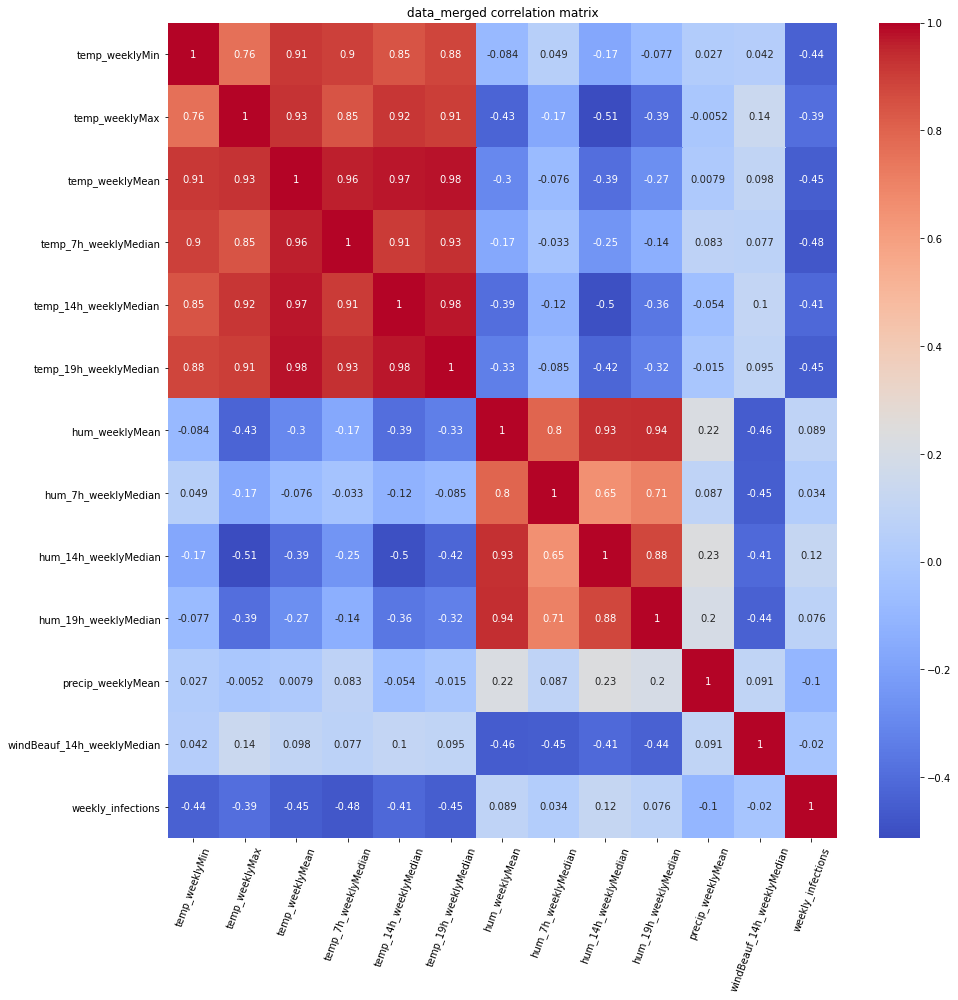

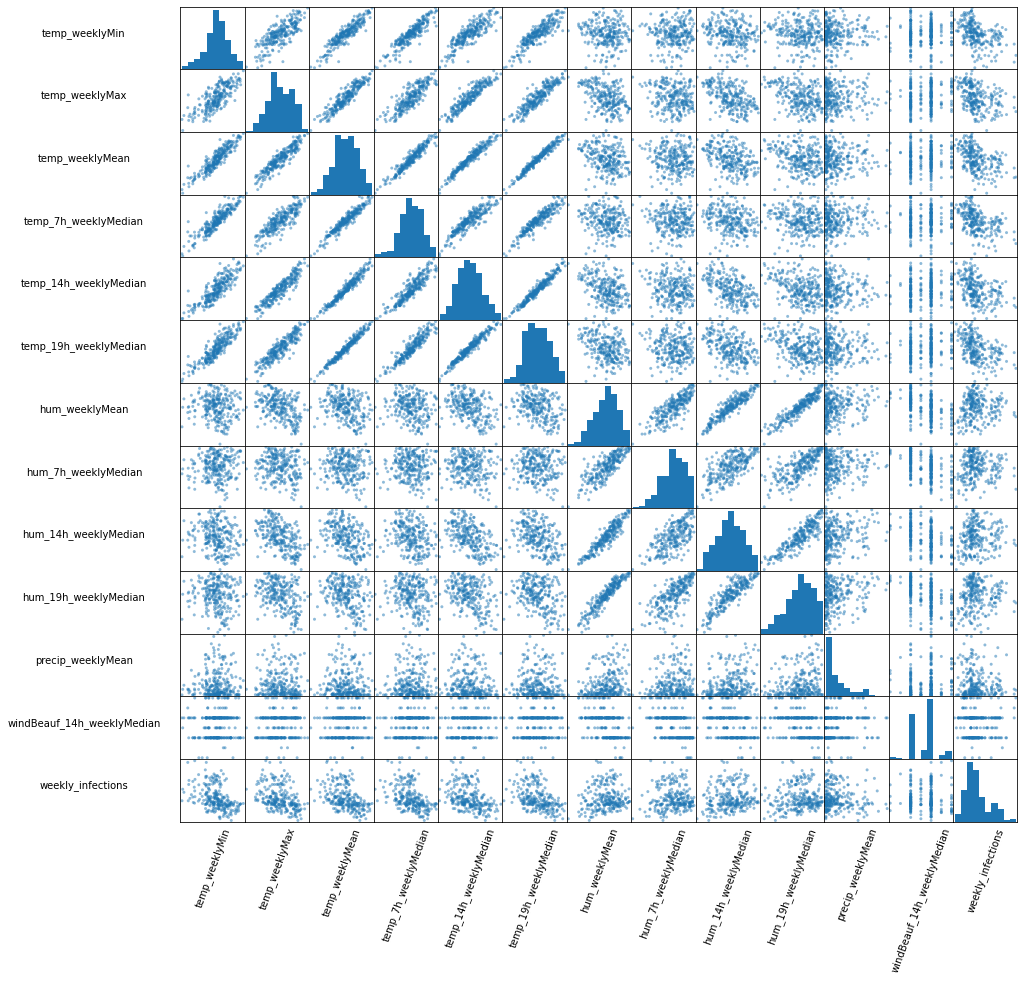

In [24]:
# correlation matrix
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data_merged.corr(), annot=True, cmap='coolwarm')
ax.set_title('data_merged correlation matrix')
plt.xticks(rotation=70)

# scatter plot matrix with histograms
sm = pd.plotting.scatter_matrix(data_merged, figsize=(15, 15), diagonal='hist')
for s in sm.reshape(-1):
    s.xaxis.label.set_rotation(70)
    s.yaxis.label.set_rotation(0)
    s.yaxis.set_label_coords(-1.5, 0.5)
    s.set_xticks(())
    s.set_yticks(())
plt.show();

#### Findings 
Summarize your findings.

The correlation matrix shows that the temperature and humidity variables are strongly positively correlated with other temperature and humidity variables, respectively. This makes sense since e.g. the mean temperature is based on the 3 daily temperature measurements etc.

precip_weeklyMean recieves a slight (positive) correlation only with the humidity variables, which again makes sense as they are both related to moisture in the air.

The humidity variables are in general moderately negatively correlated to temperature variables. windBeauf_14_weeklyMedian is also moderately negatively correlated to humidity variables.

The relationship between weekly_infections and the other variables is probably the most interesting because of Task 7 -- here only the temperature variables seem to have a stronger correlation with weekly_infections (of around -0.4/-0.5).

All of these findings are also visually represented in the scatter plot matrix. Those variables that had a strong positive correlation appear to be more linear (i.e. the data points are more grouped around the 45 degree line).

The histograms on the diagonal of the matrix generally show that the values are unimodally distributed with little skewness. Only precip_weeklyMean is quite right-skewed, as most values there tend to be around 0.

## Task 7: Influenza prediction model 
Total number of points for completing this task: **35**


Build a model to predict the number of influenza incidents for the first part of the 2019/<span style="color:red">2020</span> Influenza season (`influenza_predict.csv`) based on data of previous years using `sklearn`. 

 - Choose appropriate machine learning algorithm(s) for the problem at hand
 - Make sure your results are reproducible
 - Don't hesitate to go back to previous steps if you notice any data quality issues
 - If your chosen algorithm has specific parameters, explore their effect with different settings using 10-fold cross-validation
 - Experiment with different training/test splits
 - If appropriate, try different scaling approaches (min/max, z-score,..).
 - How good does your model fit when you evaluate it with the test data set?
 - How good are your predictions when you use the data entries in `influenza.csv` for 2019 as a validation set?
 - Present your results (e.g. by plotting predicted against true values)
 

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best model R^2: 0.09316446610442419
Best model training set MSE: 8532352.798674345
Best model test set MSE: 8668878.604006333
Best model influenza_predict.csv MSE: 6595611.571501731
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Best model R^2: 0.15103168100951228
Best model params: {'model__alpha': 1.0, 'model__l1_ratio': 0.1}
Best model training set MSE: 8950833.104198907
Best model test set MSE: 8265087.393643914
Best model influenza_predict.csv MSE: 7163670.174354374


[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    0.3s finished


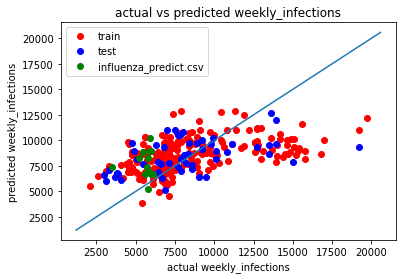

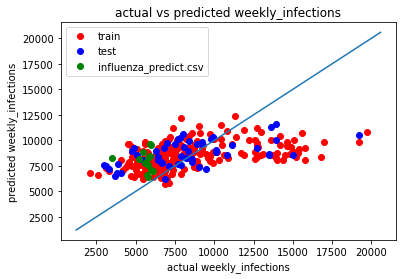

In [25]:
def load_influenza_predict_data():
    """ 
    Load and prepare the influenza_predict data file
    
    Returns
    --------
    data_merged_predict: data frame containing the influenza and data_weather_weekly data
    """
    influenza_data = pd.read_csv('data/influenza/influenza_predict.csv', header=0, na_values='-',
                                 usecols=['Neuerkrankungen pro Woche', 'Jahr', 'Kalenderwoche'])
    
    influenza_data.columns=['year', 'week', 'weekly_infections']
    
    influenza_data.dropna(inplace=True)
    influenza_data['weekly_infections'] = influenza_data['weekly_infections'].astype(int)
    influenza_data['week'] = influenza_data['week'].str[:-7].astype(int)
    
    influenza_data.set_index(['year', 'week'], inplace=True)
    data_merged_predict = merge_data(data_weather_weekly, influenza_data)
    
    return data_merged_predict


def plot_results(y_train, y_pred_train, y_test, y_pred_test, y_ip, y_pred_ip):
    """ 
    Create scatter plot of actual vs predicted data.
    
    Parameters
    --------
    y_train: observed training set data
    y_pred_train: predicted training set data
    y_test: observed test set data
    y_pred_test: predicted test set data
    y_ip: observed influenza_predict.csv data
    y_pred_ip: predicted influenza_predict.csv data
    """
    fig, ax = plt.subplots()
    ax.plot(y_train, y_pred_train, 'ro', label='train')
    ax.plot(y_test, y_pred_test, 'bo', label='test')
    ax.plot(y_ip, y_pred_ip, 'go', label='influenza_predict.csv')
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    plt.legend(loc="upper left")
    ax.set_xlabel('actual weekly_infections')
    ax.set_ylabel('predicted weekly_infections')
    ax.set_title('actual vs predicted weekly_infections');


# data handling ------------------------------------------------------------------------------------------   

X = data_merged.drop(['weekly_infections'], axis=1)
y = data_merged['weekly_infections']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

data_predict = load_influenza_predict_data()
X_ip = data_predict.drop(['weekly_infections'], axis=1)
y_ip = data_predict['weekly_infections']

# linear regression --------------------------------------------------------------------------------------

pipeline = Pipeline([
#     ('scale', StandardScaler()),
#     ('scale', MinMaxScaler()),
    ('model', LinearRegression())
])

gscv = GridSearchCV(estimator=pipeline, param_grid={}, cv=10, verbose=2, n_jobs=-1).fit(X_train, y_train)
print('Best model R^2: {}'.format(gscv.best_score_))

y_pred_train = gscv.predict(X_train)
print('Best model training set MSE: {}'.format(mean_squared_error(y_train, y_pred_train)))
y_pred_test = gscv.predict(X_test)
print('Best model test set MSE: {}'.format(mean_squared_error(y_test, y_pred_test)))
y_pred_ip = gscv.predict(X_ip)
print('Best model influenza_predict.csv MSE: {}'.format(mean_squared_error(y_ip, y_pred_ip)))

plot_results(y_train, y_pred_train, y_test, y_pred_test, y_ip, y_pred_ip)

# elasticnet ---------------------------------------------------------------------------------------------

params = {
    'model__alpha': [0.25, 0.5, 0.5, 1.0],
    'model__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
}

pipeline = Pipeline([
    ('scale', StandardScaler()),
#     ('scale', MinMaxScaler()),
    ('model', ElasticNet(tol=1e-3))
])

gscv = GridSearchCV(estimator=pipeline, param_grid=params, cv=10, verbose=2, n_jobs=-1).fit(X_train, y_train)
print('Best model R^2: {}'.format(gscv.best_score_))
print('Best model params: {}'.format(gscv.best_params_))

y_pred_train = gscv.predict(X_train)
print('Best model training set MSE: {}'.format(mean_squared_error(y_train, y_pred_train)))
y_pred_test = gscv.predict(X_test)
print('Best model test set MSE: {}'.format(mean_squared_error(y_test, y_pred_test)))
y_pred_ip = gscv.predict(X_ip)
print('Best model influenza_predict.csv MSE: {}'.format(mean_squared_error(y_ip, y_pred_ip)))

plot_results(y_train, y_pred_train, y_test, y_pred_test, y_ip, y_pred_ip)

#### Approach and algorithm
Motivate your approach and choice of algorithm in the cell below

Two models were used -- LinearRegression and ElasticNet.

LinearRegression was chosen due to its simplicity and lack of parameters that need to be fine tuned. 10-fold CV was applied on the training set and returned a model with the best R^2 score. The mean standard error was then calculated for best CV model on the training and test sets, and for the influenza_predict.csv data. 

ElasticNet was chosen since it is a regularized linear regression model that combines the L1 and L2 weight penalties. Its alpha and l1_ratio parameters were adjusted through 10-fold GridSearchCV and this again gave a model with the best R^2 score and combination of parameters. That model was used to compute the MSEs similar to LinearRegression.

MinMaxScaler, StandardScaler and no-scaling approaches were tested for both models.

The obtained predictions were plotted against the actual values to better visualize model performance.

Two train-test splits were tested -- 80-20 and 70-30.

#### Findings 
Summarize your findings and lessons learned.

The best LinearRegression model achieved an R^2 score of 0.0932. The MSEs that it got on the training and test sets were similar. Oddly enough, the MSE on the influenza_predict.csv data ended up being noticeably lower than the test and train ones. Scaling seemed to have no effect on the model's performance, so it was commented out in the pipeline.

The best ElasticNet model had the parameters alpha=1.0 (the default) and l1_ratio=0.1 (almost only the L2 penalty), and its R^2 score was 0.1510 which signifies a better performance than LinearRegression. The MSEs for the training and test set were again similar, with the test set MSE actually being lower (and also lower than the LinearRegression one). Here too was the influenza_predict.csv MSE lower than the others, but higher compared to LinearRegression. This model performed best with StandardScaler so it was kept in the pipeline. Using MinMaxScaler resulted in a slightly lower R^2 (0.1491), and no scaling had R^2=0.1283.

The plots show that the data points are more closely grouped together for ElasticNet. Both models seem to give too low predictions when the actual weekly_infections are higher. Consequently, the data points seem to follow a horizontal line more than the 45-degree line. This could also explain why the influenza_predict.csv MSEs were lower than the test/train MSEs -- the models give better predictions for lower values, and the actual influenza_predict.csv weekly_infections are all like that.

The 70-30 train-test split resulted in poorer performance, so it was commented out.